In [1]:
# Setup

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import missingno as msno
import random
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
import numpy as np 
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
# Gerando o Dataset de acordo com os parâmetros da questão

teta = np.arange(0,20,.002)

x_espiral_1 = np.array(((teta/4)*np.cos(teta)).ravel()).T
y_espiral_1 = np.array(((teta/4)*np.sin(teta)).ravel()).T
x_espiral_2 = np.array(((teta/4 + 0.8)*np.cos(teta)).ravel()).T
y_espiral_2 = np.array(((teta/4 + 0.8)*np.sin(teta)).ravel()).T

df1 = pd.DataFrame()
df1["x_espiral"] = x_espiral_1
df1["y_espiral"] = y_espiral_1
df1["label"] = 0

df2 = pd.DataFrame()
df2["x_espiral"] = x_espiral_2
df2["y_espiral"] = y_espiral_2
df2["label"] = 1

frames = [df1, df2]
df = pd.concat(frames, ignore_index=True)

In [3]:
# Aplicando noise aos dados

df_noise = df.sample(frac=0.15)

TAM = df_noise['label']
X_noise = df_noise[["x_espiral", "y_espiral"]]
y_noise = np.random.randint(2, size=(len(TAM)))

y_noise = pd.DataFrame(y_noise)
y_noise['index'] = TAM.index
X_noise['index'] = X_noise.index

df_noise = X_noise.set_index('index').join(y_noise.set_index('index'))

df_noise = df_noise.rename(columns={0:'label'})
len(df_noise)

3000

In [4]:
# Plotagem das espirais com noise
rel = [df_noise, df]
df_final = pd.concat(rel, ignore_index=True)

final_e1 = df_final[df_final.label==1]
final_e0 = df_final[df_final.label==0]

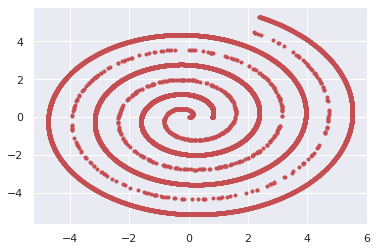

In [5]:
plt.scatter(final_e1["x_espiral"],final_e1["y_espiral"], marker='.', color='r')
#plt.scatter(final_e0["x_espiral"],final_e0["y_espiral"], marker='.', color='g')
plt.show()

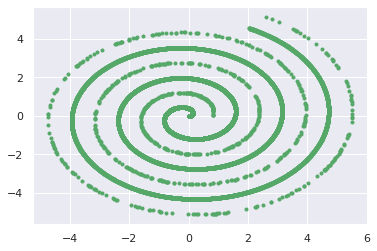

In [6]:
plt.scatter(final_e0["x_espiral"],final_e0["y_espiral"], marker='.', color='g')
#plt.scatter(final_e1["x_espiral"],final_e1["y_espiral"], marker='.', color='r')

plt.show()

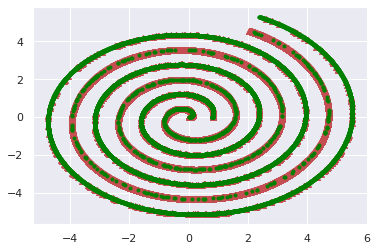

In [7]:
plt.scatter(final_e0["x_espiral"],final_e0["y_espiral"], marker='^', color="r")
plt.scatter(final_e1["x_espiral"],final_e1["y_espiral"], marker='.', color="green")
plt.show()

In [8]:
# Gerando o DatasetFinal para o Autoencoder
X = df_final.drop('label', axis=1)
y = df_final.label

In [9]:
# Função que plota os valores classificados pelo Autoencoder no final

def tsne_plot(x, y): 
	
	# Setting the plotting background 
	sns.set(style ="whitegrid") 
	
	tsne = TSNE(n_components = 2, random_state = 0) 
	
	# Reducing the dimensionality of the data 
	X_transformed = tsne.fit_transform(x) 

	plt.figure(figsize =(12, 8)) 
	
	# Building the scatter plot 
	plt.scatter(X_transformed[np.where(y == 0), 0], 
				X_transformed[np.where(y == 0), 1], 
				marker ='o', color ='r', linewidth ='1', 
				alpha = 0.8, label ='espiral0') 
	plt.scatter(X_transformed[np.where(y == 1), 0], 
				X_transformed[np.where(y == 1), 1], 
				marker ='^', color ='g', linewidth ='1', 
				alpha = 0.8, label ='espiral1') 

	# Specifying the location of the legend 
	plt.legend(loc ='best') 
	
	# Plotting the reduced data 
	plt.show() 

In [10]:
# Escalando os dados para torná-los adequados para o autoencoder

X_scaled = MinMaxScaler().fit_transform(X) 
X_0_scaled = X_scaled[y == 0] 
X_1_scaled = X_scaled[y == 1] 

In [11]:
# Input Layer 
input_layer = Input(shape =(X.shape[1], )) 

# ------------------- 1º AutoEncoder -----------------------------------------
# 1º Encoder 
encoded = Dense(200, activation ='tanh', 
				activity_regularizer = tf.keras.regularizers.l1(10e-5))(input_layer) 
encoded = Dense(100, activation ='tanh', 
				activity_regularizer = tf.keras.regularizers.l1(10e-5))(encoded) 
encoded = Dense(50, activation ='tanh', 
				activity_regularizer = tf.keras.regularizers.l1(10e-5))(encoded)  

# 1º Decoder  
decoded = Dense(25, activation ='tanh')(encoded) 
decoded = Dense(50, activation ='tanh')(decoded) 
decoded = Dense(100, activation ='tanh')(decoded) 
decoded = Dense(200, activation ='tanh')(decoded) 

# ------------------- 2º AutoEncoder -----------------------------------------
# 2º Encoder - A entrada recebe a saída do Decoder anterior
encoded = Dense(200, activation ='tanh', 
				activity_regularizer = tf.keras.regularizers.l1(10e-5))(decoded)
encoded = Dense(100, activation ='tanh', 
				activity_regularizer = tf.keras.regularizers.l1(10e-5))(encoded) 
encoded = Dense(50, activation ='tanh', 
				activity_regularizer = tf.keras.regularizers.l1(10e-5))(encoded)  

# 2º Decoder  
decoded = Dense(25, activation ='tanh')(encoded) 
decoded = Dense(50, activation ='tanh')(decoded) 
decoded = Dense(100, activation ='tanh')(decoded) 
decoded = Dense(200, activation ='tanh')(decoded)

# Output Layer 
output_layer = Dense(X.shape[1], activation ='tanh')(decoded) 

In [12]:
# Definição dos parâmetros do Autoencoder

autoencoder = Model(input_layer, output_layer) 
autoencoder.compile(optimizer ="adam", loss ="mse", metrics=['accuracy']) 
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_6 (Dense)              (None, 100)               5100

In [13]:
# Treinamento do Autoencoder
hist = autoencoder.fit(X_0_scaled, X_0_scaled,
                       batch_size = 210, epochs = 600, 
											 shuffle = True, validation_split = 0.20)

Train on 9231 samples, validate on 2308 samples
Epoch 1/600
9231/9231 [==============================] - 1s 108us/step - loss: 0.3676 - accuracy: 0.7781 - val_loss: 0.3074 - val_accuracy: 0.6590
Epoch 2/600
9231/9231 [==============================] - 1s 55us/step - loss: 0.1977 - accuracy: 0.8786 - val_loss: 0.1949 - val_accuracy: 0.9389
Epoch 3/600
9231/9231 [==============================] - 1s 56us/step - loss: 0.1492 - accuracy: 0.8350 - val_loss: 0.1694 - val_accuracy: 0.8458
Epoch 4/600
9231/9231 [==============================] - 1s 58us/step - loss: 0.1111 - accuracy: 0.9058 - val_loss: 0.1430 - val_accuracy: 0.9159
Epoch 5/600
9231/9231 [==============================] - 1s 56us/step - loss: 0.0894 - accuracy: 0.8939 - val_loss: 0.1296 - val_accuracy: 0.9766
Epoch 6/600
9231/9231 [==============================] - 1s 55us/step - loss: 0.0814 - accuracy: 0.8462 - val_loss: 0.1344 - val_accuracy: 0.9727
Epoch 7/600
9231/9231 [==============================] - 1s 57us/step - los

In [14]:
# Avaliação do treinamento 

test_loss, test_acc = autoencoder.evaluate(X_1_scaled, X_1_scaled, verbose=2)

In [15]:
test_loss

0.0025686959084911597

In [16]:
test_acc

0.9664950966835022

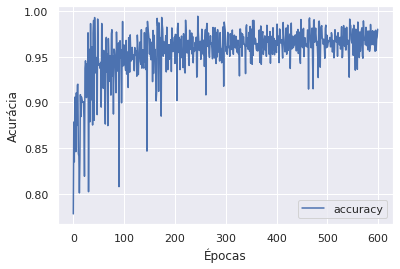

In [17]:
# Plotando a acurácia do treinamento

plt.plot(hist.history['accuracy'], label='accuracy')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [18]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_6 (Dense)              (None, 100)               5100

In [19]:
# Entendendo o comportamento do autoencoder na camada de saída

esp_0_autoencoder_rep = autoencoder.predict(X_0_scaled) 
esp_1_autoencoder_rep = autoencoder.predict(X_1_scaled) 

autoencoder_X = np.append(esp_0_autoencoder_rep, esp_1_autoencoder_rep, axis = 0) 
y_esp_0_autoencoder = np.zeros(esp_0_autoencoder_rep.shape[0]) 
y_esp_1_autoencoder = np.ones(esp_1_autoencoder_rep.shape[0]) 
autoencoder_y = np.append(y_esp_0_autoencoder, y_esp_1_autoencoder) 

autoencoder_y = pd.DataFrame(autoencoder_y)
autoencoder_y = autoencoder_y.rename({0:'label'}, axis=1)
autoencoder_X = pd.DataFrame(autoencoder_X)
autoencoder_X = autoencoder_X.rename({0:'x', 1:'y'}, axis=1)

autoencoder_df = autoencoder_X.join(autoencoder_y)

In [20]:
x_0 = autoencoder_df[autoencoder_df.label == 0]
x_1 = autoencoder_df[autoencoder_df.label == 1]

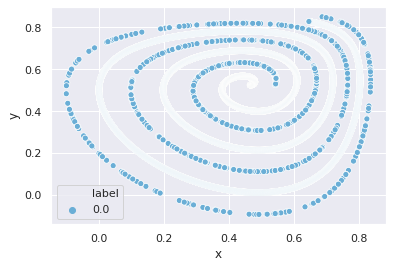

In [21]:
sns.scatterplot(x_0['x'], x_0['y'], hue=x_0.label, palette="Blues")

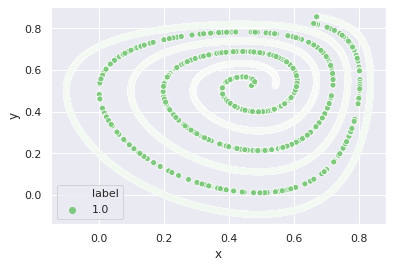

In [22]:
sns.scatterplot(x_1['x'], x_1['y'], hue=x_1.label, palette="Accent")

In [23]:
# Entendendo o comportamento do autoencoder na camada de encoder
encoder = Model(input_layer,encoded)

esp_0_hidden_rep = encoder.predict(X_0_scaled) 
esp_1_hidden_rep = encoder.predict(X_1_scaled) 

encoded_X = np.append(esp_0_hidden_rep, esp_1_hidden_rep, axis = 0) 
y_esp_0 = np.zeros(esp_0_hidden_rep.shape[0]) 
y_esp_1 = np.ones(esp_1_hidden_rep.shape[0]) 
encoded_y = np.append(y_esp_0, y_esp_1) 

encoder_y = pd.DataFrame(encoded_y)
encoder_y = encoder_y.rename({0:'label'}, axis=1)
encoder_X = pd.DataFrame(encoded_X)
encoder_X = encoder_X.rename({0:'x', 1:'y'}, axis=1)

encoder_df = encoder_X.join(encoder_y)

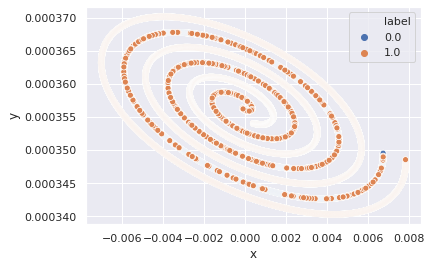

In [24]:
sns.scatterplot(encoder_df['x'], encoder_df['y'], hue=encoder_df['label'])